In [1]:
import sys
import re
import glob
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import Markdown, display
from liwc import Liwc
from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups

In [2]:
nlp = spacy.load("en_core_web_sm")
def printmd(string):
    display(Markdown(string))

In [3]:
files = glob.glob('./output/*.txt')

df_list = []

for filename in files:
    df_file = pd.read_csv(filename, sep=';')
    df_list.append(df_file)

df = pd.concat(df_list, axis=0, ignore_index=True)
print("Read", len(files), "files and loaded", df.shape[0], "rows into the dataframe.")

Read 65 files and loaded 20902 rows into the dataframe.


In [4]:
hypothetical_indicators = ["would", "could", "'d",  "can", "might", "may", "if", "then", "unless"]

def make_regex(lex_list):
    separator = '\\b|\\b'
    reg_string = separator.join(lex_list)
    reg_string_whole_word = "\\b" + reg_string + "\\b"
    return reg_string_whole_word

def count_lexicon_terms(sentence, lexicon):
    reg_str = make_regex(lexicon)
    num_matches = len(list(re.finditer(reg_str, sentence)))
    return num_matches
    

In [5]:
def match_lexicon_terms(sentence, lexicon):
    reg_str = make_regex(lexicon)
    reg_matches = re.findall(reg_str, sentence.lower())
    reg_split = re.split(reg_str, sentence.lower())
    ind = 0
    matched_print = ""
    for split_string in reg_split:
        if ind == len(reg_matches) :
            str_to_concat = split_string
        else :
            str_to_concat = split_string + '**' + reg_matches[ind] + '**'
            ind += 1
        matched_print += str_to_concat
    return matched_print
    
def print_lines(df, dataset, session, lexicon, start, num_lines=10):
    df1 = df[df['dataset'] == dataset]
    df2 = df1[df1['session'] == session]
    speakers_list = list(df2['speaker'])
    utt = list(df2['utterance'])
    end = start + num_lines
    for ind, line in enumerate(utt[start:end]) :
        index = ind + start
        line_matched = match_lexicon_terms(line, lexicon)
        print(str(index)+' : ', end='')
        print(speakers_list[index])
        printmd(line_matched)
        print('----------')

In [6]:
def add_count(df, lex_category_name, lex_category_list, normalize_measure=False):
    if lex_category_name in df.columns :
        print("Column already exists for", lex_category_name, ". Repopulating...")
        df = df.drop(lex_category_name, axis=1)
    column_index = len(df.columns)
    category_measures = []
    for ind, utterance in enumerate(list(df['utterance'])) :
        if utterance != '' and utterance != ' ' :
            category_measure = count_lexicon_terms(utterance, lex_category_list)
            category_measures.append(category_measure)
    df.insert(column_index, lex_category_name, category_measures, True)
    return df

In [7]:
df = add_count(df, 'hypotheticals', hypothetical_indicators)

In [8]:
df[10:20]

,dataset,session,speaker,utterance,hypotheticals
10,dtrs-10,grad-2-concept-review-sharon,Steve,Yeah. I like the storyboard. Are the numbers...,0
11,dtrs-10,grad-2-concept-review-sharon,Wilson,Uh. I think that it’s not that easy.,0
12,dtrs-10,grad-2-concept-review-sharon,Steve,To me they are a little bit bold. They I think...,6
13,dtrs-10,grad-2-concept-review-sharon,Wilson,What is this stuff?,0
14,dtrs-10,grad-2-concept-review-sharon,Steve,"Yeah, what is that dot there for?",0
15,dtrs-10,grad-2-concept-review-sharon,Sharon,Just a dot.,0
16,dtrs-10,grad-2-concept-review-sharon,Steve,I’d get rid of the dot. [Laughter] It looks l...,0
17,dtrs-10,grad-2-concept-review-sharon,Marlen,It’s like an inverted “I”. [0:04:00],0
18,dtrs-10,grad-2-concept-review-sharon,Steve,Yeah. Tell me about conception. What does th...,0
19,dtrs-10,grad-2-concept-review-sharon,Sharon,What?,0


In [9]:
df_counts = pd.DataFrame(columns = ['dataset', 'type', 'line count', 'percentage'])
dataset_list = list(set(list(df['dataset'])))
for dataset in dataset_list :
    df1 = df[df['dataset'] == dataset]
    category_column = df1['hypotheticals']
    non_category_count = sum(category_count == 0 for category_count in category_column)
    category_count = len(category_column) - non_category_count
    total = len(category_column)
    df_counts = df_counts.append({
        'dataset' : dataset, 
        'type' : 'hypotheticals', 
        'line count' : category_count, 
        'percentage' : round(category_count/total * 100, 2)
    }, ignore_index=True)
    df_counts = df_counts.append({
        'dataset' : dataset, 
        'type' : 'non hypotheticals', 
        'line count' : non_category_count, 
        'percentage' : round(non_category_count/total * 100, 2)
    }, ignore_index=True)
    df_counts = df_counts.append({
        'dataset' : dataset, 
        'type' : 'total', 
        'line count' : total, 
        'percentage' : round(total/total * 100, 2)
    }, ignore_index=True)

df_counts = df_counts.sort_values("dataset")
df_counts

,dataset,type,line count,percentage
9,dtrs-02,hypotheticals,591,22.85
10,dtrs-02,non hypotheticals,1995,77.15
11,dtrs-02,total,2586,100.00
3,dtrs-07,hypotheticals,1321,27.91
4,dtrs-07,non hypotheticals,3412,72.09
5,dtrs-07,total,4733,100.00
6,dtrs-10,hypotheticals,1321,25.52
7,dtrs-10,non hypotheticals,3855,74.48
8,dtrs-10,total,5176,100.00
0,dtrs-11,hypotheticals,2150,25.57


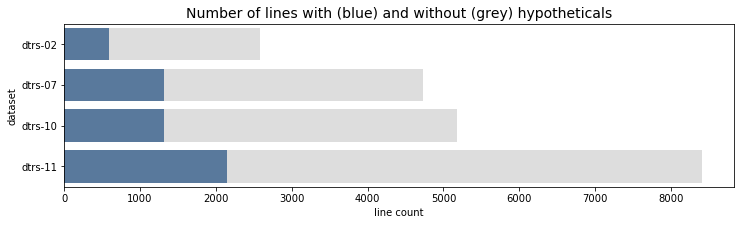

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 3)
bars = sns.barplot(x = 'line count', y = 'dataset', color = "#dddddd",
                   data = df_counts[df_counts.type == 'total'])
bars.set_title("Number of lines with (blue) and without (grey) hypotheticals", fontsize=14)
bars = sns.barplot(x = 'line count', y = 'dataset', color = "#4e79a7",
                   data = df_counts[df_counts.type == 'hypotheticals'])

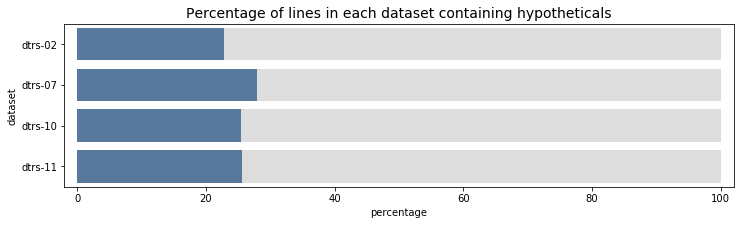

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 3)
bars = sns.barplot(x = 'percentage', y = 'dataset', color = "#dddddd",
                   data = df_counts[df_counts.type == 'total'])
bars.set_title("Percentage of lines in each dataset containing hypotheticals", fontsize=14)
plt.xlim([-2, 102])
bars = sns.barplot(x = 'percentage', y = 'dataset', color = "#4e79a7",
                   data = df_counts[df_counts.type == 'hypotheticals'])


# Other Data to Plot
 - Same as above, but for "transportation"
 - (look up what happens in Vegas dataset)
 - Do above for ALL of the data (not separated by dataset)
 - Consider individual "hypothetical" indicator and plot them separately.
 - Add KWIC to the above
 - Add "memory" keywords "recall", "remember", "used to"
 - Tense analysis in general (for past tense)
 - Sentiment analysis, then look specifically for "agreement", "judgment" terms
 - Word cloud for each dataset (remove selective stop words)
 - What constitutes "grammar of a design conversation"?
 

# For InferKit
Send peter stripped-down datasets separately, and with duplication (with same number of lines) (**Done**)